In [1]:
using FloatingTableView
using Statistics
using Impute 
using CairoMakie
using AlgebraOfGraphics
using Plots
include("dataProcessing.jl")

returnFunction (generic function with 1 method)

1.) Fetch The Main Exchange Price Data

In [2]:
africanExchanges = ["BSE","GSE","JSE","LUSE","MSE","NSE","USE","ZSE","NGX","BRVM"]

fullMarketDate = DataFrame(MarketDate = collect(Dates.Date(2017,12,01):Dates.Day(1):Dates.Date(2022,08,10)))

exchangesMktData = DataFrame(
    MarketDate=Date[],
    Exchange = Union{Missing,String}[],
    Price =  Union{Missing,Float64}[])
    
for exchange in africanExchanges   
    priceData = getProcessedData(exchange)
    ans = leftjoin(fullMarketDate, priceData, on = :MarketDate) |> sort |> Impute.locf
    append!(exchangesMktData,ans)     
end

 2.) Data Cleaning 

In [3]:
cleanMarketData = 
    exchangesMktData |> 
    exchangesMktData -> filter(:MarketDate => >=(Date("2018-01-02","y-m-d")),exchangesMktData)|>
    exchangesMktData -> transform(exchangesMktData,:Price .=> ByRow(Float64),renamecols = false) |>
    exchangesMktData -> transform(groupby(exchangesMktData,:Exchange),:MarketDate => :MarketDate,:Price .=> returnFunction => :Returns)

first(cleanMarketData,5)

5×4 DataFrame
 Row │ MarketDate  Exchange                 Price    Returns     
     │ Date        String?                  Float64  Float64     
─────┼───────────────────────────────────────────────────────────
   1 │ 2018-01-02  Botswana Stock Exchange  8860.13   0.0
   2 │ 2018-01-03  Botswana Stock Exchange  8862.22   0.00023586
   3 │ 2018-01-04  Botswana Stock Exchange  8861.72  -5.64209e-5
   4 │ 2018-01-05  Botswana Stock Exchange  8861.89   1.91835e-5
   5 │ 2018-01-06  Botswana Stock Exchange  8861.89   0.0

3.) Exploratory Data Analysis 
- Visualizing Market Price Overtime.
- Visualizing market returns overtime
- Visualizing average returns overtime

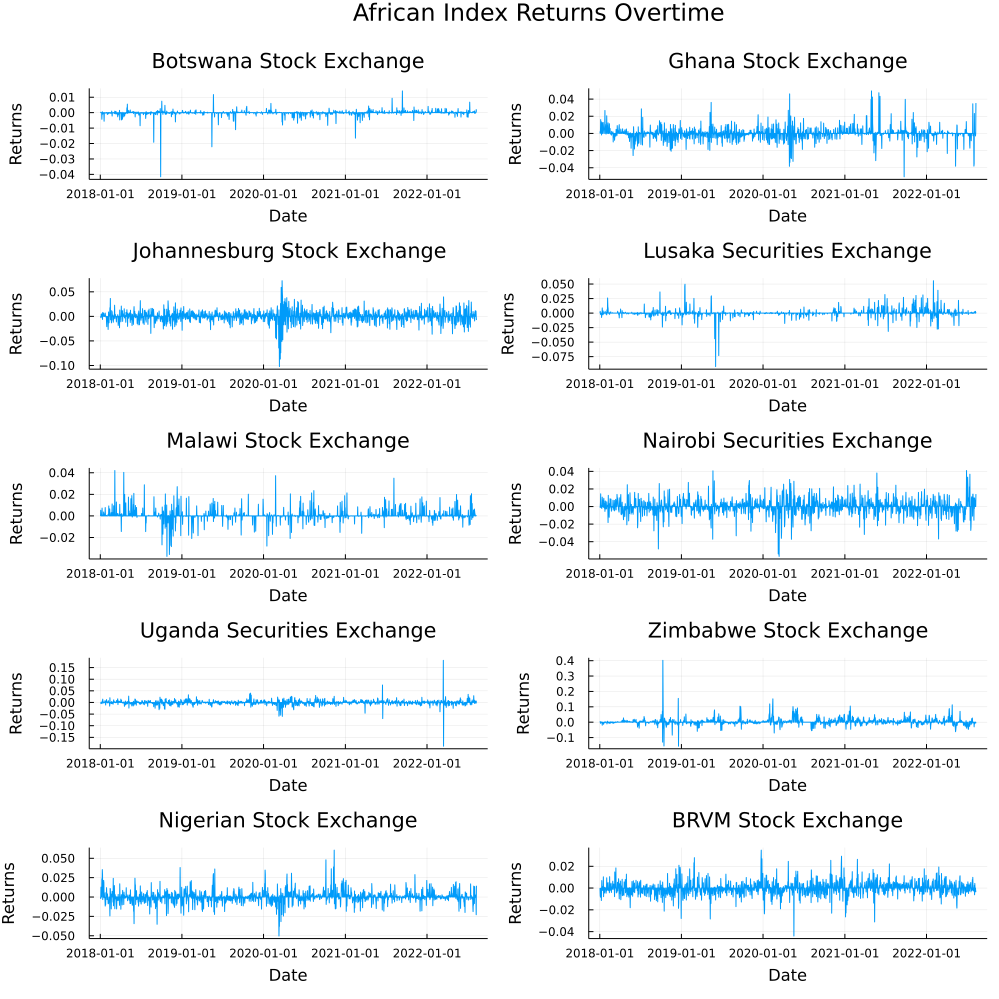

In [4]:
function  generateReturnPlot(cleanMarketData::AbstractDataFrame,Exchange::String,column::String)
        
    pltOutput = Plots.plot(cleanMarketData[:,:MarketDate],
                             cleanMarketData[:,column],
                            #group = cleanMarketData[:,:Exchange],
                            title  = Exchange,
                            linewidth=1.0,
                            size = (900,800),
                            legend = false)
    return pltOutput
end

returnPlotArray = [] 
pricePlotArray = [] 

for (key,value) in pairs(groupby(cleanMarketData,:Exchange))
    push!(returnPlotArray, generateReturnPlot(value,string(key[1]),"Returns"))
    push!(pricePlotArray, generateReturnPlot(value,string(key[1]),"Price"))
end

Plots.plot(returnPlotArray...,
           layout=(5,2),
           size = (1000,1000),        
           xlabel = "Date",
           ylabel = "Returns",
           ink=:all,
           plot_title  = "African Index Returns Overtime")

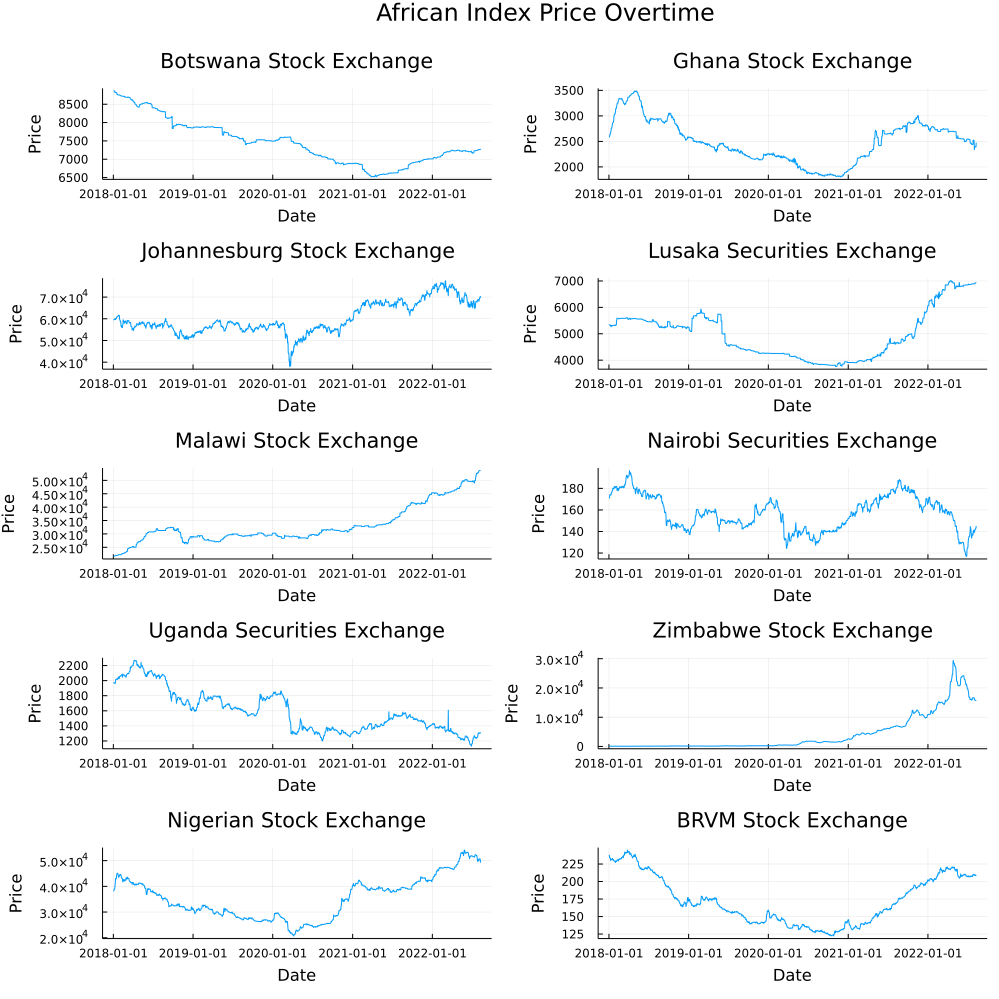

In [5]:
Plots.plot(pricePlotArray...,
           layout=(5,2),
           size = (1000,1000),  
           xlabel = "Date",
           ylabel = "Price",
           ink=:all,
           plot_title  = "African Index Price Overtime")

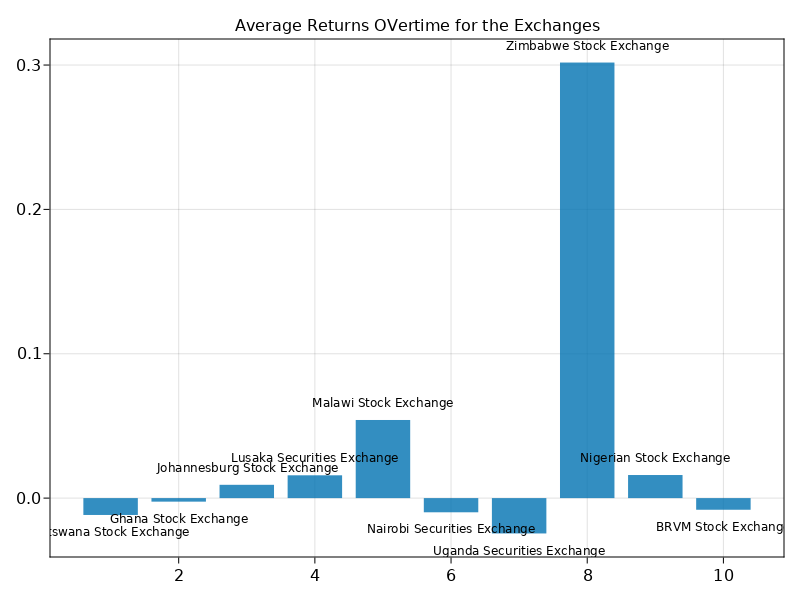

In [6]:
meanDf = combine(groupby(cleanMarketData,:Exchange),:Returns => mean => :MeanReturn)
meanDf[!,:MeanReturn] = meanDf[:,:MeanReturn] .* 100.0

barplot(meanDf[:,:MeanReturn],
    bar_labels = meanDf[:,:Exchange],
    axis = (title="Average Returns OVertime for the Exchanges",),
    label_size = 12,
    flip_labels_at=(-0.8, 0.8),
    label_offset = 10,
    label_rotation = 0.0 )

- Periodic returns,
6Months,1Year,3year and 5 years return overtime.

In [7]:
#6,1,3,5 year return 
#Geometric Return Function.
GeometricLink(input::AbstractVector{Float64}) = (reduce(*,  (input .+ 1.0))) - 1.0

function getPeriodicReturns(inputDf::AbstractDataFrame,period::Int)
    refDate = last(inputDf[:,:MarketDate]) - Dates.Month(period)
    newColName = string(string(period) ," ","Month Return")
    res = 
        inputDf |>
        inputDf -> filter(:MarketDate => >=(refDate),inputDf) |>
        inputDf -> combine(inputDf,:Returns => GeometricLink => newColName)
    return res[1,1] 
end

periods = [3,6,12,36,60]
periodicRets = zeros(10,length(periods))  

for (i,gdf) in zip(1:10,groupby(cleanMarketData,:Exchange))
     periodicRets[i,:] = map(x -> (getPeriodicReturns(gdf,x) .* 100.0),periods)
end

ColNames = string.(string.(periods) ," ","Month Return")
periodicReturnsDF = hcat(DataFrame(keys(groupby(cleanMarketData,:Exchange))),DataFrame(periodicRets,ColNames))
first(periodicReturnsDF,5)


5×6 DataFrame
 Row │ Exchange                     3 Month Return  6 Month Return  12 Month R ⋯
     │ String                       Float64         Float64         Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Botswana Stock Exchange            0.752195         2.75402         8.5 ⋯
   2 │ Ghana Stock Exchange              -8.41299         -9.80063       -10.6
   3 │ Johannesburg Stock Exchange        3.74663        -10.1663         -0.3
   4 │ Lusaka Securities Exchange         2.59381          7.42037        47.6
   5 │ Malawi Stock Exchange             12.6065          20.3242         41.5 ⋯
                                                               3 columns omitted

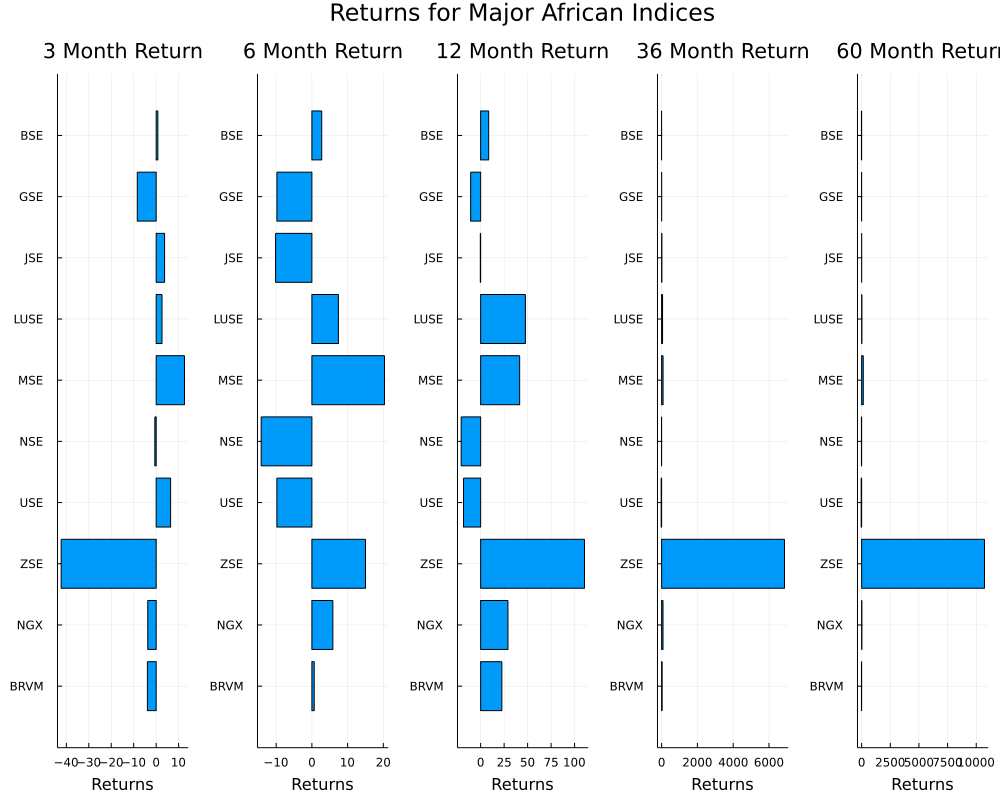

In [8]:
function generatePlot(df::AbstractDataFrame,col::String)
        
    labels = africanExchanges 
    barLabels = string.(round.(df[:,col];digits=2))

    pltOutPut = 
        Plots.plot(df[:,col],
                seriestype = :bar,
                orientation=:h,
                yticks = (1:length(labels),labels),
                yflip = true,
                size = (600,700),
                title  = col,
                legend=false)    

    return pltOutPut
end

x = names(periodicReturnsDF)[2:end][1]
plot_array = [] 
for x in names(periodicReturnsDF)[2:end]
    push!(plot_array, generatePlot(periodicReturnsDF,x))
end

labels = string.(periodicReturnsDF[:,:Exchange])

Plots.plot(plot_array...,
           layout=(1,5),
           size = (1000,800),
           plot_yticks = (1:length(labels),labels),
           xlabel = "Returns",
           plot_ylabel = "Exchange",
           ink=:all,
           plot_title  = "Returns for Major African Indices")


Check for correlation among the indexes

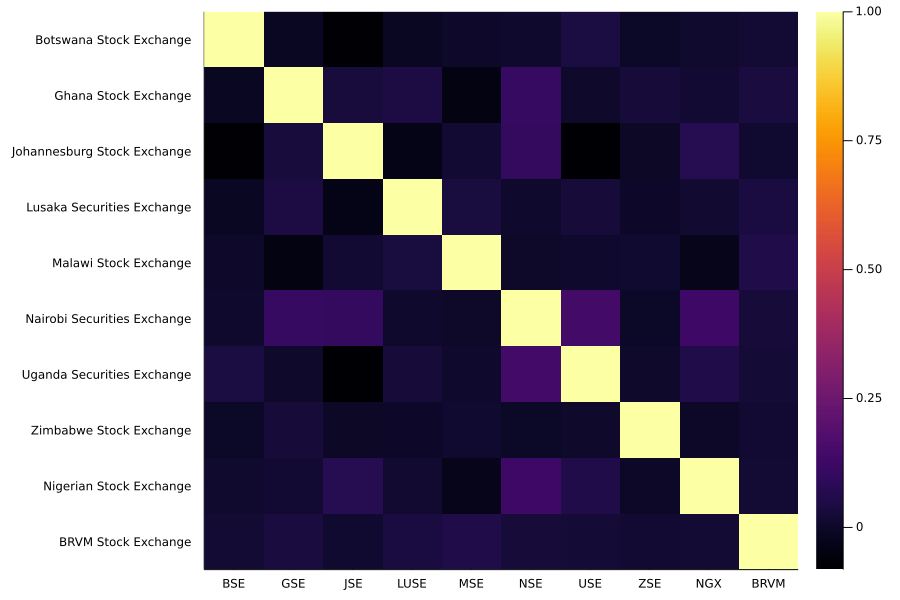

In [9]:
Matrix(cleanMarketData[:,Not(:MarketDate)])

exchangeNames = names(select(unstack(cleanMarketData,:MarketDate,:Exchange,:Returns),Not(:MarketDate)))
corrMat = cor(Matrix(select(unstack(cleanMarketData,:MarketDate,:Exchange,:Returns),Not(:MarketDate))))
Plots.heatmap(africanExchanges,exchangeNames,corrMat, yflip=true,size=(900,600))